In [ ]:
# Pip install method (recommended)
import os
from IPython import display
import torch
from IPython.display import display, clear_output
import cv2
torch.cuda.is_available()
from ultralytics import YOLO
import pyautogui
from PIL import Image
import numpy as np
import speech_recognition as sr
from fen_chess_data.utils import find_max_contour_area, find_outer_corners, do_perspective_transform
import chess
import whisper
import numpy as np
import io
import soundfile as sf
import threading
from openai import OpenAI
device = "cuda" if torch.cuda.is_available else "cpu"
torch.cuda.empty_cache()
print(f"Using {device}")
HOME = os.getcwd()
# when voice is called, it will take the last frame and run the detection on it,

In [ ]:
file_path = "E:/Github/Chess-voice-recognition-v2/best.pt"
model_data = torch.load(file_path)
print(model_data)

In [ ]:
file_path = "E:/Github/Chess-voice-recognition-v2/board_flip_detect.pt"
model_data = torch.load(file_path)
print(model_data)

In [ ]:
class ObjectDetection:
    def __init__(self, capture_index):
        self.capture_index = capture_index
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        torch.cuda.empty_cache()
        self.model = self.load_model("E:/Github/Chess-voice-recognition-v2/best.pt")
        self.board_model = self.load_model("E:/Github/Chess-voice-recognition-v2/board_flip_detect.pt")
        self.voice_model = whisper.load_model("tiny")#.to(self.device)
        self.square_coords = {}  # Will store notation -> coordinates mapping
        self.coord_notation = {}  # Will store coordinates -> notation mapping
        self.piece_coords = {}
        self.Piece_notation = {}
        self.pieces_names = ["knight", "king", "queen", "bishop", "rook"]
        self.notations_names = [chess.square_name(name) for name in chess.SQUARES]
        self.recognizer = sr.Recognizer()
        self.mic = sr.Microphone()
        self.recognizer.energy_threshold = 1
        self.recognizer.dynamic_energy_threshold = True
        self.board = chess.Board()
        self.square_coord_orig = {}
        self.coord_notation_orig = {}
    def load_model(self, filepath):
        model = YOLO(filepath)
        model.fuse()
        return model
    def predict(self,frame):
        results = self.model(frame,conf = 0.3, verbose = False)
        return results
    def predict_board(self, frame):
        results = self.board_model(frame, conf = 0.7, verbose = False)
        return results
    def detect_corners(self, frame):
        #convert to grayscale for some reason
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        thresh  = cv2.adaptiveThreshold(
            src = gray,
            maxValue = 255, 
            adaptiveMethod = cv2.ADAPTIVE_THRESH_MEAN_C,
            thresholdType = cv2.THRESH_BINARY_INV,
            blockSize = 9,
            C = 3
        )
        # Find contours detect boundaries of objects, the curve joining along a boundary of an object that have the same color
        contours, _  = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Find the largest contour, the chessboard
        contours = find_max_contour_area(contours)
        if not contours:
            return None
        #Find corners from the contours
        c = contours[0]
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        corners = find_outer_corners(frame, approx)
        return corners
    def plot_bounding_boxes(self, results):
        top_left_bottom_right_coords = []
        self.piece_coords = {}
        for result in results:
            box = result.boxes.cpu().numpy()
            top_left_bottom_right_coords.append(box.xyxy)
            if len(box.cls) != 0:
                for index, cls_id in enumerate(box.cls):
                    if self.model.names[int(cls_id)] not in self.piece_coords:
                        self.piece_coords[self.model.names[int(cls_id)]] = [box.xyxy[index]]
                    else:
                        self.piece_coords[self.model.names[int(cls_id)]].append(box.xyxy[index])    
        return results[0].plot(), top_left_bottom_right_coords
    def generate_notations_position(self, frame, x_coords, y_coords):
        square_coords = {}
        coord_notation = {}
        x_min, x_max = int(min(x_coords)), int(max(x_coords))
        y_min, y_max = int(min(y_coords)), int(max(y_coords))
        square_width = (x_max - x_min) / 8
        square_height = (y_max - y_min) / 8
        # Draw vertical grid lines
        for i in range(9):
            x = int(x_min + i * square_width)
            cv2.line(frame, (x, y_min), (x, y_max), (0, 255, 0), 1)
        
        # Draw horizontal grid lines
        for i in range(9):
            y = int(y_min + i * square_height)
            cv2.line(frame, (x_min, y), (x_max, y), (0, 255, 0), 1)
        # Look for the "a1" notation    
        x1 = int(x_min + square_width)
        y1 = int(y_max - square_height)
        # crop to the a1 square to see whether it is a1 or h8(the board is flipped)
        frame1 = frame[y1:y_max, x_min:x1]
        grayframe = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
        resized_grayframe = cv2.resize(grayframe, (640,640))
        resized_grayframe = cv2.merge([resized_grayframe, resized_grayframe, resized_grayframe])
        predicted_results = self.predict_board(resized_grayframe)
        files = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
        ranks = ['8','7','6','5','4','3','2','1']
        if (len(predicted_results[0].boxes.cls.cpu().numpy()) != 0):
            predicted_notation = int(predicted_results[0].boxes.cls.cpu().numpy()[0])
            if (predicted_notation == 1):
                ranks = ranks[::-1]
                files = files[::-1]
        # Draw square notations
        for file_idx, file in enumerate(files):
            for rank_idx, rank in enumerate(ranks):
                # Calculate square corners
                x1 = int(x_min + file_idx * square_width)
                y1 = int(y_min + rank_idx * square_height)
                x2 = int(x1 + square_width)
                y2 = int(y1 + square_height)
                
                # Calculate center of square for text
                center_x = (x1 + x2) // 2
                center_y = (y1 + y2) // 2
                
                # Draw square notation
                notation = file + rank

                cv2.putText(
                    frame,
                    notation,
                    (center_x - 10, center_y + 10),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.4,
                    (0, 255, 0),
                    1
                )
                
                square_coords[notation] = (center_x, center_y)
                coord_notation[(center_x, center_y)] = notation 
        return square_coords, coord_notation  
    def generate_notations_position_resized(self, frame,x_max, x_min, y_max, y_min):
        square_width = (x_max - x_min) / 8
        square_height = (y_max - y_min) / 8
        # Draw vertical grid lines
        for i in range(9):
            x = int(x_min + i * square_width)
            cv2.line(frame, (x, y_min), (x, y_max), (0, 255, 0), 1)
        
        # Draw horizontal grid lines
        for i in range(9):
            y = int(y_min + i * square_height)
            cv2.line(frame, (x_min, y), (x_max, y), (0, 255, 0), 1)
        # Look for the "a1" notation    
        x1 = int(x_min + square_width)
        y1 = int(y_max - square_height)
        # crop to the a1 square to see whether it is a1 or h8(the board is flipped)
        frame1 = frame[y1:y_max, x_min:x1]
        grayframe = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
        resized_grayframe = cv2.resize(grayframe, (640,640))
        resized_grayframe = cv2.merge([resized_grayframe, resized_grayframe, resized_grayframe])
        predicted_results = self.predict_board(resized_grayframe)
        files = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
        ranks = ['8','7','6','5','4','3','2','1']
        if (len(predicted_results[0].boxes.cls.cpu().numpy()) != 0):
            predicted_notation = int(predicted_results[0].boxes.cls.cpu().numpy()[0])
            if (predicted_notation == 1):
                ranks = ranks[::-1]
                files = files[::-1]
        # Draw square notations
        for file_idx, file in enumerate(files):
            for rank_idx, rank in enumerate(ranks):
                # Calculate square corners
                x1 = int(x_min + file_idx * square_width)
                y1 = int(y_min + rank_idx * square_height)
                x2 = int(x1 + square_width)
                y2 = int(y1 + square_height)
                
                # Calculate center of square for text
                center_x = (x1 + x2) // 2
                center_y = (y1 + y2) // 2
                
                # Draw square notation
                notation = file + rank

                cv2.putText(
                    frame,
                    notation,
                    (center_x - 10, center_y + 10),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.4,
                    (0, 255, 0),
                    1
                )
                
                self.square_coords[notation] = (center_x, center_y)
                self.coord_notation[(center_x, center_y)] = notation
    def modify_piece_coords(self, piece_coords):
        for name in piece_coords:
            for idx, piece in enumerate(piece_coords[name]):
                x_min, y_min, x_max, y_max = piece 
                x_middle = (x_min + x_max) / 2
                y_middle = (y_min + y_max) / 2
                piece_coords[name][idx] = int(x_middle), int(y_middle)
        return piece_coords
    def place_piece_notation(self, square_coords, piece_coords):
        Piece_notation = {}
        for notation, n_coord in square_coords.items():
            for piece, p_coord in piece_coords.items():
                for coord in p_coord: 
                    if abs(n_coord[0] - coord[0]) < 10 and abs(n_coord[1] - coord[1]) < 10:
                        if piece == 'w_pawn':
                            Piece_notation[notation] = 'P'
                        elif piece == 'w_king':
                            Piece_notation[notation] = 'K'
                        elif piece == 'w_queen':
                            Piece_notation[notation] = 'Q'
                        elif piece == 'b_pawn':
                            Piece_notation[notation] = 'p'
                        elif piece == 'b_king':
                            Piece_notation[notation] = 'k'
                        elif piece == 'b_queen':
                            Piece_notation[notation] = 'q'
                        elif piece == 'w_rook':
                            Piece_notation[notation] = 'R'
                        elif piece == 'b_rook':
                            Piece_notation[notation] = 'r'
                        elif piece == 'w_knight':
                            Piece_notation[notation] = 'N'
                        elif piece == 'b_knight':
                           Piece_notation[notation] = 'n'
                        elif piece == 'w_bishop':
                            Piece_notation[notation] = 'B'
                        elif piece == 'b_bishop':
                            Piece_notation[notation] = 'b'
                        break
            if notation not in Piece_notation:
                Piece_notation[notation] = 'nan'
        return Piece_notation
    def generate_fen_key(self,Piece_Notation):
        fen_key = ''
        for i in range(8,0,-1):
            empty_consec_counts = 0
            line = ''
            for notation in Piece_Notation.keys():
                if notation in [letter + str(i) for letter in ['a','b','c','d','e','f','g','h']]:
                    if Piece_Notation[notation] == 'nan':
                        empty_consec_counts += 1
                    else :
                        if empty_consec_counts != 0: 
                            line += str(empty_consec_counts)
                            empty_consec_counts = 0
                        line += Piece_Notation[notation]
            if empty_consec_counts == 8:
                line += '8'
            elif empty_consec_counts > 0:
                line += str(empty_consec_counts)
            if i != 1:
                fen_key += line + '/'
            else:
                fen_key += line
        return fen_key
    def crop_frame(self, frame, x_coords, y_coords): # crop the frame based on the big corner
        # get x_min and x_max and y_min and y_max to create the biggest corner which is the chessboard
        x_min, x_max = int(min(x_coords)), int(max(x_coords))
        y_min, y_max = int(min(y_coords)), int(max(y_coords))
        
        # crop the frame based on the big corner
        frame = frame[y_min:y_max, x_min:x_max]
        height, width, _ = frame.shape
        resized_x_min, resized_y_min = 0,0
        resized_x_max, resized_y_max = width + 1, height + 1
        return frame,resized_x_min, resized_y_min,resized_x_max, resized_y_max    
    def generate_from_to_positions(self, board, command):
        legal_moves = board.legal_moves
        command = command.strip().lower()
        command_list = command.split()
        filtered_command = ""
        for word in command_list:
            word = word.lower().strip()
            if (word == "night"):
                word = "knight"
            if word in self.pieces_names or word in self.notations_names:
                filtered_command += word + " "
        if (len(filtered_command) == 0):
            return "lmao", "lmao"
        filtered_command = filtered_command.strip()
        command_list = filtered_command.split()
        if (command_list[0].lower().strip() not in self.pieces_names and command_list[1].lower().strip() not in self.notations_names):
            return "lmao", "lmao"
        if (command_list[0].lower().strip() in self.notations_names and len(command_list) == 2 and command_list[1].lower().strip() in self.notations_names):
            fq = command_list[0]
            tq = command_list[1]
            return fq, tq
        else:
            if (len(command_list) == 1) :
                for move in legal_moves:
                    if chess.square_name(move.to_square) == command and board.piece_at(move.from_square).piece_type == chess.PAWN:
                        tq = chess.square_name(move.to_square)
                        fq = chess.square_name(move.from_square)
                        result = fq + " " + tq
                        return result.split()[0], result.split()[1]
            if (len(command_list) == 2):
                if (command_list[1]) not in self.notations_names:
                    piece1 = command_list[0]
                    piece2 = command_list[1]
                    for move in legal_moves:
                        piece_from_square = chess.piece_name(board.piece_at(move.from_square).piece_type)
                        if board.piece_at(move.to_square) is not None:
                            piece_to_square = chess.piece_name(board.piece_at(move.to_square).piece_type)
                            if (piece_from_square == piece1.lower() and piece_to_square == piece2.lower()):
                                tq = chess.square_name(move.to_square)
                                fq = chess.square_name(move.from_square)
                                result = fq + " " + tq
                                return result.split()[0], result.split()[1]
                else:
                    piece_name = command_list[0]
                    to_square = command_list[1]
                    for move in legal_moves:
                        if chess.square_name(move.to_square) == to_square and board.piece_at(move.from_square).piece_type == getattr(chess, piece_name.upper()):
                            tq = chess.square_name(move.to_square)
                            fq = chess.square_name(move.from_square)
                            result = fq + " " + tq
                            return result.split()[0], result.split()[1]
        return "lmao", "lmao"
    def move_mouse(self, from_x, from_y, to_x, to_y):
        pyautogui.moveTo(from_x, from_y)
        pyautogui.mouseDown()
        pyautogui.moveTo(to_x, to_y)
        pyautogui.mouseUp()
    def screenshot(self):
        screenshot = pyautogui.screenshot()
        frame = np.array(screenshot)
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        return frame
    def listen_and_move(self):
        print("Listening")
        with self.mic as source:
            while (True):
                audio = self.recognizer.listen(source, phrase_time_limit = 5)
                raw_audio = np.frombuffer(audio.frame_data, dtype = np.int16)
                volume_level = np.abs(raw_audio).max()
                print("Volume: ", volume_level)
                if volume_level > 10000:
                    print("Transcribing")
                    wav_bytes = audio.get_wav_data(convert_rate = 16000)
                    wav_stream = io.BytesIO(wav_bytes)
                    audio_array, _ = sf.read(wav_stream)
                    audio_array = audio_array.astype(np.float32)
                    result = self.voice_model.transcribe(
                        audio_array, 
                        language = "en",
                        fp16 = torch.cuda.is_available(),
                        without_timestamps = True
                    )
                    text = result['text'].strip()
                    print("Recognized: ", text)
                    if 'stop' in text.strip().lower():
                        break
                    fsquare, tsquare = self.generate_from_to_positions(self.board, text)
                    if fsquare == "lmao" and tsquare == "lmao":
                        print("Could not recognize move, try again")
                        continue
                    from_x, from_y = self.square_coord_orig[fsquare]
                    to_x, to_y = self.square_coord_orig[tsquare]
                    self.move_mouse(from_x, from_y, to_x, to_y)
    def __call__(self):
        while True:
            frame = self.screenshot()
            corners = self.detect_corners(frame)
            if corners is not None:
                # get the coordinates of the corners
                x_coords = [corner[0] for corner in corners]
                y_coords = [corner[1] for corner in corners]
                self.square_coord_orig, self.coord_notation_orig = self.generate_notations_position(frame, x_coords, y_coords)
                frame, resized_x_min, resized_y_min,resized_x_max, resized_y_max = self.crop_frame(frame,x_coords, y_coords)
                self.generate_notations_position_resized(frame, resized_x_max, resized_x_min, resized_y_max, resized_y_min)
                results = self.predict(frame)
                #plot the predicted results onto the frame 
                predicted_img, top_left_bottom_right_coords = self.plot_bounding_boxes(results)
                # modify for center x center y
                self.piece_coords = self.modify_piece_coords(self.piece_coords)
                self.Piece_Notation = self.place_piece_notation(self.square_coords,self.piece_coords)
                fen_key = self.generate_fen_key(self.Piece_Notation)
                self.board = chess.Board(fen_key)
                # clear_output(wait = True)
                # display(self.board)
                cv2.imshow("Screen capture", predicted_img)
                # if (self.board.is_valid()):
                #     print("board is valid")
                if not hasattr(self, "listening_thread"):
                    self.listening_thread = threading.Thread(target=self.listen_and_move, daemon=True)
                    self.listening_thread.start()
            if cv2.waitKey(1) & 0xFF == ord("q"):
                return self.square_coords,self.piece_coords, self.board
square_coords, piece_coords, board = ObjectDetection(0)()

In [24]:
import ollama

prompt = "Convert the following text to chess notation and only chess notation. For example, if the text is ""Rook captures night"", then you print ""rook knight"", if the text is be sure of dee to, you can convert to bishop d2 and the following, try to convert to chess notation. For the pawn, if the text is ""pawn to e2"", only produce e2. if the text is ""e22e5"" then you can infer its ""e2 e5"". Remember, ONLY GIVE THE CHESS NOTATION.Here is the text: "
response = ollama.chat(model="mistral", messages=[{"role": "user", "content": prompt + "C1 to d2"}])

print(response['message']['content']) 


 c2 d2


In [ ]:
white_legal_moves = list(board.legal_moves)
board.turn = not board.turn
black_legal_moves = list(board.legal_moves)
all_legal_moves = white_legal_moves + black_legal_moves

In [ ]:
answer = "knight d5"
display(board)
piece_name, notation = answer.split()[0], answer.split()[1]
if piece_name == "knight":
    for square in chess.SQUARES:
        piece = board.piece_at(square)
        if piece is not None and piece.piece_type == chess.KNIGHT:
            print(str(chess.square_name(square)) + notation)
            move = chess.Move.from_uci(str(chess.square_name(square)) + notation)
            if move in board.legal_moves:
                board.push(move)
                break
            else: 
                board.turn = not board.turn
                if move in board.legal_moves:
                    board.push(move)
                    break
                
board

## Number detection test

In [ ]:
from IPython.display import display, Image
image = "E:/Github/Chess-voice-recognition-v2/3.png"
image = cv2.imread(image)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
cv2.imwrite("gray.png",gray)
Image(filename = "gray.png")


In [ ]:
gray.shape

In [ ]:
model = YOLO("E:/Github/Chess-voice-recognition-v2/board_flip_detect.pt")
model.fuse()

In [23]:
image = "E:/Github/Chess-voice-recognition-v2/gray.png"
image = cv2.imread(image)
frame = np.array(image)
frame = cv2.resize(frame, (640,640))
results = model(frame,conf = 0.3, verbose = False)

In [ ]:
frame.shape

In [ ]:
results[0].boxes.conf.cpu().numpy()

## Voice recognition using Whisper

In [ ]:
import whisper 
model = whisper.load_model("large")

In [ ]:
result = model.transcribe("output.wav")
transcribed_text = result['text']

In [ ]:
transcribed_text

In [ ]:
import pyaudio
import wave
import time

FORMAT = pyaudio.paInt16 # 16-bit resolution 
CHANNELS = 1 #Mono audio
RATE = 44100 # 44.1kHz sampling rate
CHUNK = 1025 # Number of frames per buffer
RECORD_SECONDS = 8
OUTPUT_FILENAME = "output.wav"

#Initialize Pyaudio object
p = pyaudio.PyAudio()

#record audio from microphone 
stream  = p.open(format = FORMAT, channels = CHANNELS, rate = RATE, input = True, frames_per_buffer = CHUNK)
print("Recording")

frames = []

for _ in range (0, int(RATE / CHUNK * RECORD_SECONDS)):
    data = stream.read(CHUNK)
    frames.append(data)

print("Finished")
stream.stop_stream()
stream.close()
p.terminate()

with wave.open(OUTPUT_FILENAME, 'wb') as wb:
    wb.setnchannels(CHANNELS)
    wb.setsampwidth(p.get_sample_size(FORMAT))
    wb.setframerate(RATE)
    wb.writeframes(b''.join(frames))

In [ ]:
import speech_recognition as sr
import numpy as np
recognizer = sr.Recognizer()
mic = sr.Microphone()
def listen_for_notation():
    print("Listening")
    with mic as source:
        recognizer.adjust_for_ambient_noise(source) # adjust for background noise
        audio = recognizer.listen(source)
    try: 
        print("Transcribing")
        result = model.transcribe(audio)
        transcription = result['text']
        return transcription
    except Exception as e:
        print("Error")
        e.printStackTrace()
        return None
listen_for_notation()

In [ ]:
import speech_recognition as sr
recognizer = sr.Recognizer()
mic = sr.Microphone()
recognizer.energy_threshold = 10
recognizer.dynamic_energy_threshold = True
while True:
        with mic as source:
                audio = recognizer.listen(source, phrase_time_limit = 2)
        raw_audio = np.frombuffer(audio.frame_data, dtype = np.int16)
        print(np.abs(raw_audio).max())
        if np.abs(raw_audio).max() > 10000:
                print("something")
                break


In [ ]:
import whisper 
import speech_recognition as sr
import numpy as np
import io
import soundfile as sf
import torch
    torch.cuda.empty_cache()
device = "cuda" if torch.cuda.is_available else "cpu"
print(device)
model = whisper.load_model("large").to(device)

In [2]:
recognizer = sr.Recognizer()
mic = sr.Microphone()
recognizer.energy_threshold = 10
recognizer.dynamic_energy_threshold = True

In [ ]:
while True:
    with mic as source:
        audio = recognizer.listen(source, phrase_time_limit = 2)
        raw_audio = np.frombuffer(audio.frame_data, dtype = np.int16)
    
    if (np.abs(raw_audio).max() > 10000):
        wav_bytes = audio.get_wav_data(convert_rate=16000)
        wav_stream = io.BytesIO(wav_bytes)
        audio_array, sampling_rate = sf.read(wav_stream)
        audio_array = audio_array.astype(np.float32)
        print("Transcribing")
        result = model.transcribe(
                    audio_array,
                    language="en",
                    fp16=torch.cuda.is_available(),
                    without_timestamps=True
                )
        print(result['text'])

## Using fine-tuned custom whisper model

In [19]:
import pyaudio
import wave
import time

FORMAT = pyaudio.paInt16 # 16-bit resolution 
CHANNELS = 1 #Mono audio
RATE = 16000
CHUNK = 1025 # Number of frames per buffer
RECORD_SECONDS = 3
OUTPUT_FILENAME = "output.wav"

#Initialize Pyaudio object
p = pyaudio.PyAudio()

#record audio from microphone 
stream  = p.open(format = FORMAT, channels = CHANNELS, rate = RATE, input = True, frames_per_buffer = CHUNK)
print("Recording")

frames = []

for _ in range (0, int(RATE / CHUNK * RECORD_SECONDS)):
    data = stream.read(CHUNK)
    frames.append(data)

print("Finished")
stream.stop_stream()
stream.close()
p.terminate()

with wave.open(OUTPUT_FILENAME, 'wb') as wb:
    wb.setnchannels(CHANNELS)
    wb.setsampwidth(p.get_sample_size(FORMAT))
    wb.setframerate(RATE)
    wb.writeframes(b''.join(frames))

Recording
Finished


In [1]:
from transformers import WhisperProcessor, WhisperForConditionalGeneration
import librosa

e:\anaconda3\envs\chess-voice-main\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
processor = WhisperProcessor.from_pretrained("Buiilding/whisper-chess")
model = WhisperForConditionalGeneration.from_pretrained("Buiilding/whisper-chess")

In [3]:
def load_audio(wav_path):
    audio, sr = librosa.load(wav_path, sr = 16000)
    input_features = processor(audio, sampling_rate = 16000, return_tensors = "pt", padding = True).input_features
    return input_features
audio_path = "output.wav"
input_features = load_audio(audio_path)

<class 'numpy.ndarray'>


In [22]:
generated_ids = model.generate(input_features, None)

In [23]:
transcription = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

In [24]:
transcription

'King H5'

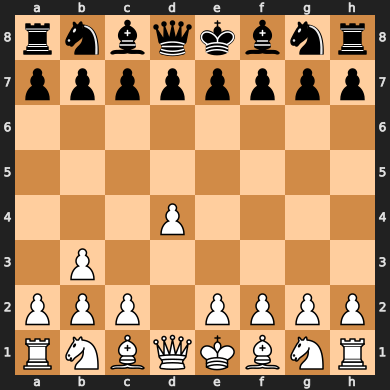

In [2]:
import chess
board = chess.Board("rnbqkbnr/pppppppp/8/8/3P4/1P6/PPP1PPPP/RNBQKBNR b KQkq - 0 1")
board

In [52]:
board.is_valid()

True

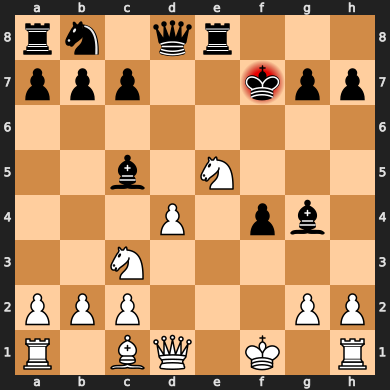

In [51]:
import chess
board = chess.Board("rn1qr3/ppp2kpp/8/2b1N3/3P1pb1/2N5/PPP3PP/R1BQ1K1R b - -")
board

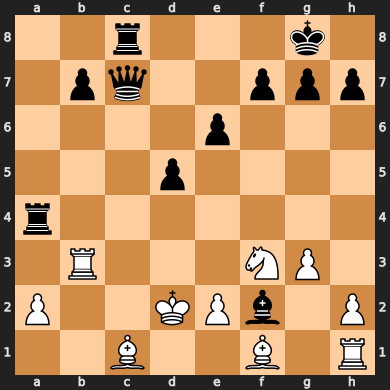

In [6]:
import chess
board = chess.Board("2r3k1/1pq2ppp/4p3/3p4/r7/1R3NP1/P2KPb1P/2B2B1R w - - 0 1")
board

In [6]:
board.legal_moves

<LegalMoveGenerator at 0x7625c81fbf70 (Nh6, Nf6, Nc6, Na6, h6, g6, f6, e6, d6, c6, b6, a6, h5, g5, f5, e5, d5, c5, b5, a5)>

In [1]:
"rnb1k1nr/ppp1pp1p/6p1/4P3/8/8/PPP2PPP/RNBqKB1R" == "rnbqk1nr/ppp1pp1p/6p1/4P3/8/8/PPP2PPP/RNBQKB1R"

False

In [1]:
pip install roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 13.7 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
Note: you may need to restart the kernel to use updated packages.


In [1]:
import roboflow

In [2]:
rf = roboflow.Roboflow(api_key = "GDzoFketEv7N4kdSkgxK")

In [3]:
workspace = rf.workspace()

loading Roboflow workspace...


In [6]:
workspace.upload_dataset(
   "/home/peter-bui/Downloads/Pavel-and-move_side",       # Path to your dataset directory
   "chess-piece-object-detection-tdpqo",       # Desired project ID (creates a new project or uses an existing one)
   num_workers=10,     # Number of concurrent uploads (adjust as needed)
   project_license="MIT",  # License type for the project
   project_type="object-detection"  # Type of project (e.g., 'object-detection', 'classification')
)

loading Roboflow project...
Uploading to existing project peter-bui/chess-piece-object-detection-tdpqo
[UPLOADED] /home/peter-bui/Downloads/Pavel-and-move_side/test/images/1B6-1nK5-7r-8-8-2k5-3b4-3B4_jpeg.rf.ca36d32beaf13cd33d024d9a54e8f887.jpg (gfpTYLtOM6ELRqvy0zse) [0.5s] / annotations = OK [0.5s]
[UPLOADED] /home/peter-bui/Downloads/Pavel-and-move_side/test/images/1B6-1B6-5r2-6k1-3q2b1-q1K5-8-1N6_jpeg.rf.d91d1218da0f04813d5eabd9c4453cf0.jpg (PCE3BSVvqjg89WNOIV6O) [0.7s] / annotations = OK [0.5s]
[UPLOADED] /home/peter-bui/Downloads/Pavel-and-move_side/test/images/1B6-1R1B4-1q6-1Kb4p-b5k1-P6Q-2bb4-6bn_jpeg.rf.1ab528c81efae984fc2bffce04e8817b.jpg (oixdGaznnJ8HxKX4r4Q3) [0.7s] / annotations = OK [0.5s]
[UPLOADED] /home/peter-bui/Downloads/Pavel-and-move_side/test/images/1B6-1r6-8-6B1-1n2k3-5N1b-8-KQ2nB2_jpeg.rf.bbe3b7b5ddc263431b93d1e26177bc46.jpg (ZsZQ8oI6jxB6yGHoUBEo) [0.7s] / annotations = OK [0.5s]
[UPLOADED] /home/peter-bui/Downloads/Pavel-and-move_side/test/images/1B6-1p6-7k-6NN-

In [8]:
workspace.upload_dataset(
   "/home/peter-bui/Downloads/all_annotations_pawns_more.v3i.yolov5pytorch",       # Path to your dataset directory
   "all_data_chess_recognition",       # Desired project ID (creates a new project or uses an existing one)
   num_workers=10,     # Number of concurrent uploads (adjust as needed)
   project_license="MIT",  # License type for the project
   project_type="object-detection"  # Type of project (e.g., 'object-detection', 'classification')
)

loading Roboflow project...
Uploading to existing project bi-nh-tun-anh/all_data_chess_recognition
[UPLOADED] /home/peter-bui/Downloads/all_annotations_pawns_more.v3i.yolov5pytorch/test/images/143_png.rf.dce23ba518ae4ef086bdf2d7bdfd0253.jpg (7fMEQDT6i2dl2rACCcNc) [0.6s] / annotations = OK [0.7s]
[UPLOADED] /home/peter-bui/Downloads/all_annotations_pawns_more.v3i.yolov5pytorch/test/images/60_png.rf.d3548604c4774a0057c9b490e1d474ac.jpg (x7s0zmo28t35vU3W1luc) [0.7s] / annotations = OK [0.6s]
[UPLOADED] /home/peter-bui/Downloads/all_annotations_pawns_more.v3i.yolov5pytorch/test/images/50_png.rf.a1b69004ec10f50ffd14c1c7d19dfc52.jpg (Z58IfxXSapti9LTSQebB) [0.7s] / annotations = OK [0.7s]
[UPLOADED] /home/peter-bui/Downloads/all_annotations_pawns_more.v3i.yolov5pytorch/test/images/51_png.rf.43ded9fa77e30b154b1ee5f9aa29d3c0.jpg (eQ9ysiSG1poZbM1bSwWm) [0.7s] / annotations = OK [0.7s]
[UPLOADED] /home/peter-bui/Downloads/all_annotations_pawns_more.v3i.yolov5pytorch/test/images/45_png.rf.f7c3cd2c

In [10]:
current  = chess.Board("1nbqkb1r/ppp2ppp/3p4/8/3Pn3/5N2/PPP2PPP/RNBQKB1R b KQk - 0 1")
previous = chess.Board("1nbqkb1r/ppp2ppp/3p4/8/4n3/5N2/PPPP1PPP/RNBQKB1R w KQk - 0 1")

In [21]:
current.is_valid()

True

In [36]:
def generate_fen_key():
    fen_key = ''
    # Add en passant target
    en_passant_target = get_en_passant_target(previous)
    fen_key += ' ' + en_passant_target

    return fen_key
def get_en_passant_target(previous_board):
    """
    Determine the en passant target square for FEN notation by checking if a pawn moved two squares.
    Returns the target square name or '-' if none.
    """
    if not previous_board:
        return '-'  # No previous board, no en passant target

    # Find the move that was made
    move = find_move(previous_board, current)
    if move:
        piece = current.piece_at(move.to_square)
        # Check if the piece is a pawn (white or black)
        if piece and piece.piece_type == chess.PAWN:
            # Verify two-square move (same file, distance of 16 squares)
            if (chess.square_file(move.from_square) == chess.square_file(move.to_square) and 
                abs(move.to_square - move.from_square) == 16):
                # White pawn moved up (e.g., e2 to e4, target e3)
                if piece.color == chess.WHITE:
                    return chess.square_name(move.to_square - 8)
                # Black pawn moved down (e.g., e7 to e5, target e6)
                else:
                    return chess.square_name(move.to_square + 8)
    return '-'  # No en passant target
def find_move(previous_board, current_board):
    """
    Find the move that was made between the previous and current board states
    """
    for move in previous_board.legal_moves:
        if previous_board.is_legal(move):
            temp_board = previous_board.copy()
            temp_board.push(move)
            if temp_board == current_board:
                return move
    return None

In [37]:
a = generate_fen_key()

In [38]:
print(a)

 d3


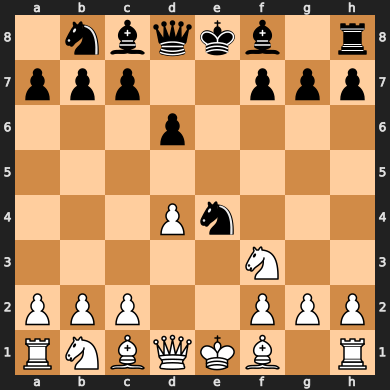

In [39]:
current

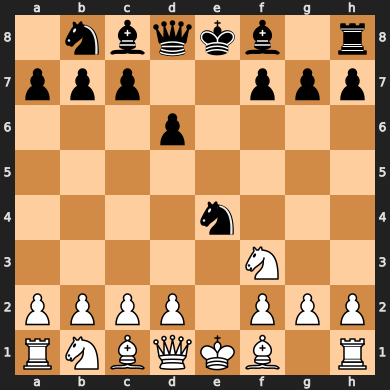

In [40]:
previous

In [50]:
after_board = chess.Board('1nbqkb1r/ppp2ppp/3p4/8/3Pn3/5N2/PPP2PPP/RNBQKB1R b KQk d3')

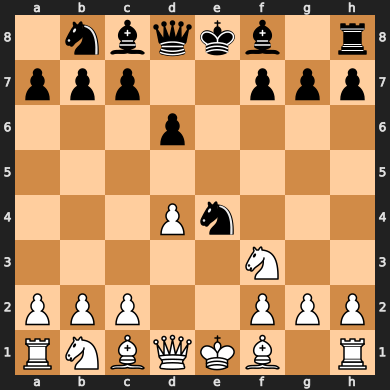

In [51]:
after_board

In [52]:
after_board.is_valid()

True